In [7]:
from __future__ import annotations

import functools
import glob
import itertools
import operator
import os
import string
import urllib.parse
from collections import defaultdict
from dataclasses import dataclass, field
from pathlib import Path
from types import MappingProxyType
from typing import NamedTuple, Callable, Literal, Final, Union

import networkx as nx
import numpy as np
import pandas as pd
import requests
from matplotlib import colors
from matplotlib import pyplot as plt
from matplotlib.colors import Colormap
from networkx import DiGraph
from numpy.typing import NDArray
from pandas import DataFrame, Index
from pyomo.environ import *
from pyomo.opt import SolverResults
from requests import Response
from rich.console import Console
from rich.text import Text

# **Setup**

In [8]:
# Create a rich console instance for formatted output
console: Final[Console] = Console()

# **Implementation**

In [9]:
class Coordinates(NamedTuple):
    """
    Representation of geographical coordinates with latitude and longitude.

    This class is designed to store geographical coordinates (latitude and longitude)
    and includes helper methods to locate a place using the OpenStreetMap API and to
    compute a distance-like measure between coordinates using a great-circle distance
    approximation. The class extends `NamedTuple` making it immutable and hashable.
    """
    lat: np.floating  # Latitude in decimal degrees
    lon: np.floating  # Longitude in decimal degrees

    @classmethod
    @functools.lru_cache
    def locate(cls, name: str) -> Coordinates:
        """
        Locate geographic coordinates for a specific place name using the Nominatim
        service. This method uses caching to improve performance for repeated
        queries. This function queries the location name and retrieves the latitude
        and longitude if the location is found.

        :param name: The name of the location to query.
        :return: A `Coordinates` object containing the latitude and longitude of
                 the specified location.
        """
        # Append "Colombia" to all queries for country-specific search
        query: str = urllib.parse.quote(f'Colombia, {name}')
        # Use custom User-Agent to comply with Nominatim's usage policy
        response: Response = requests.get(f"https://nominatim.openstreetmap.org/search?q={query}&format=json&limit=1", headers={"User-Agent": "Coordinates API"})
        assert response.ok
        data: dict[str, str]
        data, *_ = response.json()  # Take the first result, discard others
        return cls(np.float64(data["lat"]), np.float64(data["lon"]))

    def __matmul__(self, other: Union[Coordinates, type[Param.Skip]]) -> Union[np.floating, type[Param.Skip]]:
        """
        Computes the Haversine distance between two coordinates.

        The Haversine formula calculates the great-circle distance between two points
        on a sphere given their longitudes and latitudes. This implementation assumes
        that both points are given in decimal degrees and converts them to radians
        internally. The final result is returned in kilometers.

        :param other: The second coordinate to compute the distance to, represented as
            an instance of the Coordinates class.
        :return: The great-circle distance between the two coordinates retrieves in kilometers.
        """
        if other is Param.Skip:
            return Param.Skip
        if not isinstance(other, Coordinates):
            return NotImplemented
        # Convert coordinates from degrees to radians
        x: NDArray[np.floating] = np.radians(np.array([self.lat, self.lon]))
        y: NDArray[np.floating] = np.radians(np.array([other.lat, other.lon]))
        diff: NDArray[np.floating] = y - x
        # Haversine formula: https://en.wikipedia.org/wiki/Haversine_formula
        # 12742.00 is Earth's diameter in kilometers (2 * 6371 km radius)
        return np.asin(np.sqrt(np.sin(diff[0] / 2) ** 2 + np.cos(x[0]) * np.cos(y[0]) * np.sin(diff[1] / 2) ** 2)) * 12742.00


@dataclass
class SolverVisualizer:
    """
    A utility class responsible for generating and displaying the visual representation
    of the vehicle routing solution for a given optimization case (I, II, or III).

    This class stores the coordinates of all places involved (depots, clients, stations)
    and the computed routing paths for each vehicle. It uses NetworkX to build a directed
    graph representing the network and renders it using matplotlib.
    """
    name: Literal["I", "II", "III"]
    depots: dict[int, Coordinates]
    clients: dict[int, Coordinates]
    stations: dict[int, Coordinates]
    vehicles: defaultdict[int, list[int]] = field(default_factory=lambda: defaultdict(list))

    def __post_init__(self) -> None:
        """
        Initializes internal data structures used for graph representation.
        """
        self._graph: DiGraph = DiGraph()
        self._names: dict[int, str] = {}

        # Initialize naming logic once since it's necessary for other components like display()
        for id in self.depots:
            self._names[id] = f"D{id}"
        for id in self.clients:
            self._names[id] = f"C{id - len(self.depots)}"
        for id in self.stations:
            self._names[id] = f"S{id - len(self.depots) - len(self.clients)}"


    @property
    def names(self) -> MappingProxyType[int, str]:
        """
        Provides read-only access to the internal mapping of place IDs to string names.
        """
        return MappingProxyType(self._names)

    def display(self) -> None:
        """
        Displays the current state of the network distribution using a graph visualization.

        The graph shows all nodes (depots, clients, and stations) and the active routes
        used by each vehicle in the solution. Each node type has a different shape and color,
        and each vehicle is assigned a unique color. The plot uses geographical positions
        (latitude and longitude) and is rendered using NetworkX and matplotlib.
        """

        console.rule(Text(f"  Visualizing Case {self.name}", style="bold cyan"), style="cyan")

        # Reset the graph and internal naming map
        self._graph.clear()
        self._names.clear()
        console.print("[blue] Graph and label map cleared.")

        # Add depot nodes to the graph with triangle shape and red color
        for id, coordinates in self.depots.items():
            self._graph.add_node(
                self._names.setdefault(id, f"PTO{id:02}"),
                pos=coordinates,
                node_type="depot",
                color="#FF0000"
            )

        # Add client nodes with circle shape and green color
        for id, coordinates in self.clients.items():
            self._graph.add_node(
                self._names.setdefault(id, f"MUN{id - len(self.depots):02}"),
                pos=coordinates,
                node_type="client",
                color="#00FF00"
            )

        # Add station nodes with squared shape and blue color
        for id, coordinates in self.stations.items():
            self._graph.add_node(
                self._names.setdefault(id, f"EST{id - len(self.depots) - len(self.clients):02}"),
                pos=coordinates,
                node_type="station",
                color="#0000FF"
            )

        console.print("[blue] Nodes added to graph (depots, clients, stations).")

        # Extract node positions and categorized node lists
        pos: dict[str, Coordinates] = nx.get_node_attributes(self._graph, "pos")
        depots: list[str] = [n for n, a in self._graph.nodes(data=True) if a.get("node_type") == "depot"]
        clients: list[str] = [n for n, a in self._graph.nodes(data=True) if a.get("node_type") == "client"]
        stations: list[str] = [n for n, a in self._graph.nodes(data=True) if a.get("node_type") == "station"]

        plt.figure(figsize=(12, 8))

        # Draw nodes with shape and color per category
        nx.draw_networkx_nodes(self._graph, pos, nodelist=depots, node_color=["#FF0000"], node_shape="^", node_size=300, label="Depots")  # type: ignore[signature-mismatch]
        nx.draw_networkx_nodes(self._graph, pos, nodelist=clients, node_color=["#00FF00"], node_shape="o", node_size=200, label="Clients")  # type: ignore[signature-mismatch]
        nx.draw_networkx_nodes(self._graph, pos, nodelist=stations, node_color=["#0000FF"], node_shape="s", node_size=250, label="Stations")  # type: ignore[signature-mismatch]

        # Label nodes
        nx.draw_networkx_labels(self._graph, pos, font_size=10, font_weight='bold')

        # Assign each vehicle a unique color using a gradient colormap
        cmap: Colormap = plt.get_cmap("twilight")
        gradient: dict[int, str] = {
            vehicle: colors.to_hex(cmap(offset))
            for vehicle, offset in zip(self.vehicles, np.linspace(0, 1, len(self.vehicles)))
        }

        for vehicle, color in gradient.items():
            plt.plot([], [], color=color, linewidth=2, label=f"Vehicle {vehicle}")

        # Draw all active edges for each vehicle
        for vehicle, path in self.vehicles.items():
            # Draw each segment of the path
            for origin, target in zip(path[:-1], path[1:]):
                route: tuple[str, str] = (self._names[origin], self._names[target])
                self._graph.add_edge(*route)
                nx.draw_networkx_edges(
                    self._graph,
                    pos,
                    edgelist=[route],
                    edge_color=gradient[vehicle],
                    width=2,
                    arrowsize=20,
                    arrows=True
                )

        # Final layout and rendering
        plt.title(f"Network Distribution - Case {self.name}")
        plt.legend()
        plt.axis("on")
        plt.ylabel("Longitude")
        plt.xlabel("Latitude")
        plt.grid(True)
        console.print("[green] Displaying network plot...\n")
        plt.show()


##  Set Definitions

### 1. **Depots** (`depots`)
- **Description:** Set of all depot nodes (starting locations).
- **Notation:**
  $$
  \text{depots} = \left\{ 1,\ 2,\ 3,\ \dots \right\}
  $$

---

### 2. **Clients** (`clients`)
- **Description:** Set of client nodes (delivery destinations).
- **Notation:**
  $$
  \text{clients} = \left\{ 1 + |\text{depots}|,\ 2 + |\text{depots}|,\ 3 + |\text{depots}|,\ \dots \right\}
  $$

---

### 3. **Stations** (`stations`)
- **Description:** Set of refueling station nodes (only in scenario II and III).
- **Notation:**
  $$
  \text{stations} = \left\{ 1 + |\text{depots}| + |\text{clients}|,\ 2 + |\text{depots}| + |\text{clients}|,\ \dots \right\}
  $$

---

### 4. **Places** (`places`)
- **Description:** Set of all possible node types (depots, clients, and stations).
- **Notation:**
  $$
  \text{places} = \text{depots} \cup \text{clients} \cup \text{stations}
  $$

---

### 5. **Routes** (`routes`)
- **Description:** Set of all valid directed arcs between different places, excluding depot-to-depot arcs.
- **Notation:**
  $$
  \text{routes} = \left\{ (origin,\ target)\ \middle|\ origin,\ target \in \text{places},\ origin \ne target,\ \neg(origin \in \text{depots} \land target \in \text{depots}) \right\}
  $$

---

### 6. **Vehicles** (`vehicles`)
- **Description:** Set of all vehicles available for routing.
- **Notation:**
  $$
  \text{vehicles} = \left\{ 1,\ 2,\ 3,\ \dots \right\}
  $$

##  Parameter Definitions

### 1. **Distances** (`distance`)
- **Description:** Distance in kilometers between each valid origin–destination route pair.
- **Notation:**
  $$
  \text{distance}_{\text{origin},\ \text{target}} \quad \forall\ (\text{origin},\ \text{target}) \in \text{routes}
  $$

---

### 2. **Client Demands** (`demand`)
- **Description:** Required cargo (in tons) to be delivered to each client.
- **Notation:**
  $$
  \text{demand}_{\text{client}} \quad \forall\ \text{client} \in \text{clients}
  $$

---

### 3. **Delivery Thresholds** (`threshold`)
- **Description:** Maximum allowable cargo that can be delivered to each client.
- **Notation:**
  $$
  \text{threshold}_{\text{client}} \quad \forall\ \text{client} \in \text{clients}
  $$

---

### 4. **Fixed Tariffs** (`tariff`)
- **Description:** Fixed toll fee per vehicle when visiting a client (if applicable).
- **Notation:**
  $$
  \text{tariff}_{\text{client}} \quad \forall\ \text{client} \in \text{clients} \text{ (if tariff applies)}
  $$

---

### 5. **Variable Surcharges** (`surcharge`)
- **Description:** Variable toll charged per ton of cargo delivered to a client (if applicable).
- **Notation:**
  $$
  \text{surcharge}_{\text{client}} \quad \forall\ \text{client} \in \text{clients} \text{ (if surcharge applies)}
  $$

---

### 6. **Vehicle Capacity** (`capacity`)
- **Description:** Maximum cargo capacity (in tons) for each vehicle.
- **Notation:**
  $$
  \text{capacity}_{\text{vehicle}} \quad \forall\ \text{vehicle} \in \text{vehicles}
  $$

---

### 7. **Vehicle Autonomy** (`autonomy`)
- **Description:** Maximum travel distance (in kilometers) a vehicle can cover with a full tank.
- **Notation:**
  $$
  \text{autonomy}_{\text{vehicle}} \quad \forall\ \text{vehicle} \in \text{vehicles}
  $$

---

### 8. **Tank Capacity** (`tank`)
- **Description:** Total fuel tank capacity (in gallons) for each vehicle.
- **Notation:**
  $$
  \text{tank}_{\text{vehicle}} \quad \forall\ \text{vehicle} \in \text{vehicles}
  $$

---

### 9. **Fuel Prices** (`gasoline`)
- **Description:** Price of fuel per gallon at each refueling station.
- **Notation:**
  $$
  \text{gasoline}_{\text{station}} \quad \forall\ \text{station} \in \text{stations}
  $$

##  Variables Definitions

### 1. **Route Decision Variables** (`visited`)
- **Definition:** Binary variable that equals 1 if a vehicle travels from `origin` to `target`, 0 otherwise.
- **Domain:** Binary
- **Scope:**
  $$
  \text{visited}_{\text{origin},\ \text{target},\ \text{vehicle}} \in \{0, 1\}
  \quad \forall\ (\text{origin},\ \text{target}) \in \text{routes},\ \text{vehicle} \in \text{vehicles}
  $$

---

### 2. **Cargo Flow Variables** (`cargo`)
- **Definition:** Amount of cargo carried by a vehicle *after leaving* a given place.
- **Domain:** Non-negative real
- **Scope:**
  $$
  \text{cargo}_{\text{place},\ \text{vehicle}} \geq 0
  \quad \forall\ \text{place} \in \text{places},\ \text{vehicle} \in \text{vehicles}
  $$

---

### 3. **Fuel Range Variables** (`range`)
- **Definition:** Remaining driving range (in kilometers) a vehicle has upon reaching a place.
- **Domain:** Non-negative real
- **Scope:**
  $$
  \text{range}_{\text{place},\ \text{vehicle}} \geq 0
  \quad \forall\ \text{place} \in \text{places},\ \text{vehicle} \in \text{vehicles}
  $$

---

### 4. **Refueling Variables** (`refuel`) *(Scenario II only)*
- **Definition:** Gallons of fuel refueled by a vehicle at a station.
- **Domain:** Non-negative real
- **Scope:**
  $$
  \text{refuel}_{\text{station},\ \text{vehicle}} \geq 0
  \quad \forall\ \text{station} \in \text{stations},\ \text{vehicle} \in \text{vehicles}
  $$

---

### 5. **Traversal Order Variables** (`traverse`)
- **Definition:** Integer indicating the visit order of a node within a vehicle’s route (used for MTZ subtour elimination).
- **Domain:** Integer from 1 to $|\text{places}|$
- **Scope:**
  $$
  \text{traverse}_{\text{place},\ \text{vehicle}} \in \{1, 2, \dots, |\text{places}|\}
  \quad \forall\ \text{place} \in \text{places},\ \text{vehicle} \in \text{vehicles}
  $$

##  Constraint Definitions

### 1. **Capacity and Autonomy Constraints**

- **Client cargo limit**
  $$
  \text{cargo}_{\text{place},\ \text{vehicle}} \leq \text{threshold}_{\text{place}} \quad \forall\ \text{place} \in \text{clients},\ \forall\ \text{vehicle} \in \text{vehicles}
  $$

- **Vehicle capacity bound**
  $$
  \text{cargo}_{\text{place},\ \text{vehicle}} \leq \text{capacity}_{\text{vehicle}} \quad \forall\ \text{place} \in \text{places},\ \forall\ \text{vehicle} \in \text{vehicles}
  $$

- **Vehicle autonomy bound**
  $$
  \text{range}_{\text{place},\ \text{vehicle}} \leq \text{autonomy}_{\text{vehicle}} \quad \forall\ \text{place} \in \text{places},\ \forall\ \text{vehicle} \in \text{vehicles}
  $$

---

### 2. **Subtour Elimination (MTZ)**

- Miller–Tucker–Zemlin constraint for non-depot places:
  $$
  \text{traverse}_{\text{origin},\ \text{vehicle}} - \text{traverse}_{\text{target},\ \text{vehicle}} + N \cdot \text{visited}_{\text{origin},\ \text{target},\ \text{vehicle}} \leq N - 1
  $$
  $$
  \forall\ \text{origin},\ \text{target} \notin \text{depots},\ \text{origin} \neq \text{target},\ \forall\ \text{vehicle} \in \text{vehicles}
  $$

---

### 3. **Depot Departure**

- Each vehicle must depart from exactly one depot:
  $$
  \sum_{\substack{\text{origin} \in \text{depots} \\ \text{target} \in \text{places}}} \text{visited}_{\text{origin},\ \text{target},\ \text{vehicle}} = 1 \quad \forall\ \text{vehicle} \in \text{vehicles}
  $$

---

### 4. **Client Visit Constraint**

- Each client is visited exactly once:
  $$
  \sum_{\substack{\text{origin} \in \text{places} \\ \text{vehicle} \in \text{vehicles}}} \text{visited}_{\text{origin},\ \text{client},\ \text{vehicle}} = 1 \quad \forall\ \text{client} \in \text{clients}
  $$

---

### 5. **Station Visit Limit (Scenario II)**

- Each station may be visited at most once:
  $$
  \sum_{\substack{\text{origin} \in \text{places} \\ \text{vehicle} \in \text{vehicles}}} \text{visited}_{\text{origin},\ \text{station},\ \text{vehicle}} \leq 1 \quad \forall\ \text{station} \in \text{stations}
  $$

---

### 6. **Arc Restrictions**

- **Single use per route**
  $$
  \sum_{\text{vehicle} \in \text{vehicles}} \text{visited}_{\text{origin},\ \text{target},\ \text{vehicle}} \leq 1 \quad \forall\ (\text{origin},\ \text{target}) \in \text{routes}
  $$

- **No return path by same vehicle**
  $$
  \text{visited}_{\text{origin},\ \text{target},\ \text{vehicle}} + \text{visited}_{\text{target},\ \text{origin},\ \text{vehicle}} \leq 1 \quad \forall\ (\text{origin},\ \text{target}) \in \text{routes},\ \forall\ \text{vehicle}
  $$

---

### 7. **Flow Conservation at All Places**

- Each vehicle entering a place must also leave it:
  $$
  \sum_{\text{origin} \in \text{places}} \text{visited}_{\text{origin},\ \text{place},\ \text{vehicle}} = \sum_{\text{target} \in \text{places}} \text{visited}_{\text{place},\ \text{target},\ \text{vehicle}} \quad \forall\ \text{place},\ \text{vehicle}
  $$

---

### 8. **Cargo Flow Preservation at Clients**

- Flow balance constraint with demand requirement:
  $$
  \sum \text{cargo}_{\text{origin},\ \text{vehicle}} - \sum \text{cargo}_{\text{client},\ \text{vehicle}} + (1 - \sum \text{visited}_{\text{origin},\ \text{client},\ \text{vehicle}}) \cdot M \geq \text{demand}_{\text{client}}
  $$

---

### 9. **Cargo Flow Preservation at Stations (Scenario II)**

- If visited, flow into and out of a station must be equal:
  $$
  \sum \text{cargo}_{\text{origin},\ \text{vehicle}} - \sum \text{cargo}_{\text{station},\ \text{vehicle}} \leq M \cdot (1 - \sum \text{visited}_{\text{origin},\ \text{station},\ \text{vehicle}})
  $$
  $$
  \sum \text{cargo}_{\text{station},\ \text{vehicle}} - \sum \text{cargo}_{\text{origin},\ \text{vehicle}} \leq M \cdot (1 - \sum \text{visited}_{\text{origin},\ \text{station},\ \text{vehicle}})
  $$

---

### 10. **Range Feasibility for Movement**

- Enforce minimum range to traverse route if visited:
  $$
  \text{range}_{\text{origin},\ \text{vehicle}} \geq \text{distance}_{\text{origin},\ \text{target}} - (1 - \text{visited}_{\text{origin},\ \text{target},\ \text{vehicle}}) \cdot M
  $$
  $$
  \forall\ (\text{origin},\ \text{target}) \in \text{routes},\ \text{target} \notin \text{depots},\ \forall\ \text{vehicle}
  $$

---

### 11. **Range Update with Refueling (Scenario II)**

- Updates range after travel and optional refuel:
  $$
  \text{range}_{\text{origin},\ \text{vehicle}} - \text{distance}_{\text{origin},\ \text{target}} + \text{refuel}_{\text{target},\ \text{vehicle}} \cdot \text{autonomy}_{\text{vehicle}} + (1 - \text{visited}_{\text{origin},\ \text{target},\ \text{vehicle}}) \cdot M \geq \text{range}_{\text{target},\ \text{vehicle}}
  $$
  $$
  \forall\ (\text{origin},\ \text{target}) \in \text{routes},\ \text{target} \notin \text{depots},\ \forall\ \text{vehicle}
  $$

##  Objective Function Definition

This model seeks to **minimize the total operational cost** of routing vehicles across depots, clients, stations, and tolls. The cost includes transportation, tolls, and refueling expenses.

---

###  **Minimize TotalCost:**

$$
\min \left( C_{\text{distance}} + C_{\text{tolls}} + C_{\text{surcharge}} + C_{\text{fuel}} \right)
$$

---

###  1. **Distance-based Transport & Maintenance Cost**

- **Description:** Cost incurred from traveling between locations, proportional to distance, freight cost, and maintenance.
- **Formula:**
  $$
  C_{\text{distance}} =
  \sum_{\text{vehicle} \in \text{vehicles}}
  \sum_{(origin, target) \in \text{routes}}
  \text{distance}_{origin,target}
  \cdot \text{visited}_{origin,target,\text{vehicle}}
  \cdot (F_t + C_m)
  $$

---

###  2. **Fixed Toll Cost (per visited client)**

- **Description:** Fixed cost applied for passing through client nodes that have tolls.
- **Formula:**
  $$
  C_{\text{tolls}} =
  \sum_{\text{vehicle} \in \text{vehicles}}
  \sum_{\substack{(origin, target) \in \text{routes} \\ target \in \text{clients}}}
  \text{tariff}_{target} \cdot \text{visited}_{origin,target,\text{vehicle}}
  $$

---

###  3. **Variable Toll Surcharge (per ton delivered)**

- **Description:** A surcharge is applied per ton of cargo delivered to specific clients.
- **Formula:**
  $$
  C_{\text{surcharge}} =
  \sum_{\text{vehicle} \in \text{vehicles}}
  \sum_{target \in \text{clients}}
  \text{surcharge}_{target} \cdot \text{cargo}_{target,\text{vehicle}}
  $$

---

###  4. **Fuel Cost (only in Scenario II and III)**

- **Description:** Vehicles may refuel at stations, paying per gallon at the local station price.
- **Formula:**
  $$
  C_{\text{fuel}} =
  \sum_{\text{vehicle} \in \text{vehicles}}
  \sum_{station \in \text{stations}}
  \text{refuel}_{station,\text{vehicle}} \cdot \text{gasoline}_{station}
  $$

---

###  **Final Objective Summary**

Combining all components, the model minimizes:

$$
\text{TotalCost} = C_{\text{distance}} + C_{\text{tolls}} + C_{\text{surcharge}} + C_{\text{fuel}}
$$

In [10]:
@dataclass
class AbstractSolver:
    """
    AbstractSolver is the main class for configuring and solving vehicle routing problems.
    It supports different scenarios (I, II, III) and prepares all data and model components
    including sets, parameters, variables, constraints, and objectives.

    Scenario types:
        - I: Basic routing (depots, clients, vehicles only)
        - II: Adds fuel stations and fuel-based constraints
        - III: Adds tolls and maximum weight per client
    """
    name: Literal["I", "II", "III"]
    depots: DataFrame
    clients: DataFrame
    vehicles: DataFrame
    stations: DataFrame = None
    tolls: DataFrame = None

    def __post_init__(self) -> None:
        """
        Performs preprocessing and setup of the optimization model after instantiation.
        This includes preparing coordinates, filling missing values, adjusting indexes,
        creating visualizer maps, initializing the Pyomo model, and constructing the
        optimization components like sets, parameters, and constraints.
        """
        console.rule(Text(f"Case {self.name!r} → Initialization", style="BOLD CYAN"), style="CYAN")

        # Copy input data to avoid mutating the original DataFrames
        self.depots = self.depots.copy()
        self.clients = self.clients.copy()
        self.vehicles = self.vehicles.copy()
        self.stations = self.stations.copy() if self.name.endswith("II") else self.stations
        self.tolls = self.tolls.copy() if self.name.endswith("III") else self.tolls

        console.print("[cyan]→ Converting coordinates...")

        # Convert depot lat/lon to Coordinates objects
        self.depots["Coordinates"] = self.depots[["Latitude", "Longitude"]].apply(
            lambda instance: Coordinates(instance["Latitude"], instance["Longitude"]), axis=1
        )
        del self.depots["Latitude"]
        del self.depots["Longitude"]

        # Convert client coordinates or look them up by name
        try:
            self.clients["Coordinates"] = self.clients[["Latitude", "Longitude"]].apply(
                lambda instance: Coordinates(instance["Latitude"], instance["Longitude"]), axis=1
            )
            del self.clients["Latitude"]
            del self.clients["Longitude"]
        except KeyError:
            self.clients["Coordinates"] = self.clients["City/Municipality"].apply(Coordinates.locate)

        # Convert station coordinates (if applicable)
        if self.name.endswith("II"):
            self.stations["Coordinates"] = self.stations[["Latitude", "Longitude"]].apply(
                lambda instance: Coordinates(instance["Latitude"], instance["Longitude"]), axis=1
            )
            del self.stations["Latitude"]
            del self.stations["Longitude"]

        # Handle missing values for scenario III (tolls and weights)
        if self.name.endswith("III"):
            self.clients["MaxWeight"] = self.clients["MaxWeight"].fillna(self.clients["Demand"].sum())
            self.tolls["BaseRate"] = self.tolls["BaseRate"].fillna(0)
            self.tolls["RatePerTon"] = self.tolls["RatePerTon"].fillna(0)

        console.print("[cyan]→ Adjusting indices...")

        # Offset client indices to avoid collisions with depots
        self.clients.index = Index(map(functools.partial(operator.add, len(self.depots)), self.clients.index), name=self.clients.index.name)

        # Offset station indices to avoid collisions with clients
        if self.name.endswith("II"):
            self.stations.index = Index(map(functools.partial(operator.add, len(self.clients)), self.stations.index), name=self.stations.index.name)

        console.print("[cyan]→ Initializing visualizer...")

        # Build visualizer maps for plotting
        self._visualizer: SolverVisualizer = SolverVisualizer(
            self.name,
            {depot: self.depots.at[depot, "Coordinates"] for depot in self.depots.index},
            {client: self.clients.at[client, "Coordinates"] for client in self.clients.index},
            {station: self.stations.at[station, "Coordinates"] for station in self.stations.index} if self.name.endswith("II") else {},
        )

        # Create the Pyomo model and choose a solver
        self._model: ConcreteModel = ConcreteModel(f"Case {self.name!r}")
        self._solve: Callable[..., SolverResults] = SolverFactory("scip").solve
        # Enforces early exit due to heavy calculations (about a month to complete one optimization)
        self._solve.__self__.options["limits/time"] = 60  # type: ignore[checker-missmatch]
        self._solve.__self__.options["limits/gap"] = 0.05  # type: ignore[checker-missmatch]

        # Verify that total vehicle capacity is enough to meet total client demand
        capacity: float = self.vehicles["Capacity"].sum()
        demand: float = self.clients["Demand"].sum()
        if capacity < demand:
            console.print(Text.assemble(
                (" Insufficient vehicle capacity detected:\n", "bold red"),
                (f"   Total available: {capacity:.2f} tons\n", "yellow"),
                (f"   Total required:  {demand:.2f} tons", "red")
            ))
            return

        # Check if any client's maximum allowed cargo is less than their demand (scenario III only)
        if self.name.endswith("III") and (self.clients["MaxWeight"] < self.clients["Demand"]).any():  # type: ignore[checker-missmatch]
            console.print(Text.assemble(
                ("  Client capacity constraints are too tight in scenario III:\n", "bold red"),
                ("   Some clients have max weight limits lower than their demands.\n", "yellow"),
                ("   You may want to increase 'MaxWeight' or relax constraints.", "red")
            ))

        console.rule(Text("Generating Model Components", style="bold yellow"), style="yellow")

        self._sets()
        console.print("[yellow]✓ Sets defined")

        self._parameters()
        console.print("[yellow]✓ Parameters initialized")

        self._variables()
        console.print("[yellow]✓ Variables declared")

        self._constraints()
        console.print("[yellow]✓ Constraints built")

        self._objective()
        console.print("[yellow]✓ Objective function set")

        console.rule(Text(f"Case {self.name!r} Initialization Completed", style="BOLD BRIGHT_GREEN"), style="BOLD GREEN")

    def _sets(self) -> None:
        """
        Defines the key sets used in the optimization model for vehicle routing.
        Sets include depots, clients, optional refueling stations (if applicable),
        valid-directed routes (excluding loops and depot-to-depot arcs), and vehicles.
        All physical locations are referred to as 'places' in this model.
        """
        # Set of depots (starting points for routes)
        self._model.depots = Set(
            initialize=self.depots.index,
        )

        # Set of clients (delivery locations with demand)
        self._model.clients = Set(
            initialize=self.clients.index,
        )

        # Optional: set of stations (refueling points, only in some project scenarios)
        if self.name.endswith("II"):
            self._model.stations = Set(
                initialize=self.stations.index,
            )

        # Set of all places (depots + clients [+ stations if applicable])
        self._model.places = Set(
            initialize=itertools.chain(
                self._model.depots,
                self._model.clients,
                self._model.stations if self.name.endswith("II") else (),
            )
        )

        # Set of valid directed routes between places:
        # - excludes loops (origin == target)
        # - excludes depot-to-depot connections
        self._model.routes = Set(
            initialize=filter(
                lambda route: operator.ne(*route) and not all(place in self._model.depots for place in route),  # type: ignore[typechecker-issue]
                itertools.product(self._model.places, self._model.places)
            )
        )

        # Set of vehicles available for assignment
        self._model.vehicles = Set(
            initialize=self.vehicles.index,
        )

    def _parameters(self) -> None:
        """
        Defines all fixed parameters used in the optimization model.

        It includes the distances between places, client demands, cargo thresholds, toll costs,
        vehicle capacities, vehicle autonomy ranges, tank sizes, and fuel prices at stations.
        Some parameters, like thresholds, tolls, and fuel prices, are only relevant in specific
        scenarios such as II or III.
        """
        # Distance in kilometers between each pair of places (based on Haversine formula)
        self._model.distance = Param(
            self._model.routes,
            initialize=lambda _, origin, target: operator.matmul(
                self.stations.at[origin, "Coordinates"] if self.name.endswith("II") and origin in self._model.stations else
                self.clients.at[origin, "Coordinates"] if origin in self._model.clients else
                self.depots.at[origin, "Coordinates"],
                self.stations.at[target, "Coordinates"] if self.name.endswith("II") and target in self._model.stations else
                self.clients.at[target, "Coordinates"] if target in self._model.clients else
                self.depots.at[target, "Coordinates"],
            )
        )

        # Demand in tons for each client place
        self._model.demand = Param(
            self._model.clients,
            initialize=lambda _, client: self.clients.at[client, "Demand"]
        )

        # Maximum cargo allowed for each client; uses a true threshold only in scenario III
        self._model.threshold = Param(
            self._model.clients,
            initialize=lambda _, client: self.clients.at[client, "MaxWeight"] if self.name.endswith("III") else sum(self._model.demand.values())
        )

        # Fixed toll charge at each place (only applicable in scenario III)
        self._model.tariff = Param(
            self._model.places,
            initialize=lambda _, place: self.tolls.at[place, "BaseRate"] if self.name.endswith("III") and place in self.tolls.index else 0
        )

        # Toll per ton of cargo delivered to each place (only applicable in scenario III)
        self._model.surcharge = Param(
            self._model.places,
            initialize=lambda _, place: self.tolls.at[place, "RatePerTon"] if self.name.endswith("III") and place in self.tolls.index else 0
        )

        # the maximum cargo capacity (in tons) for each vehicle
        self._model.capacity = Param(
            self._model.vehicles,
            initialize=lambda _, vehicle: self.vehicles.at[vehicle, "Capacity"],
        )

        # The maximum distance each vehicle can travel on a full tank (in kilometers)
        self._model.autonomy = Param(
            self._model.vehicles,
            initialize=lambda _, vehicle: self.vehicles.at[vehicle, "Range"],
        )

        # Total fuel tank capacity of each vehicle (in gallons)
        self._model.tank = Param(
            self._model.vehicles,
            initialize=lambda _, vehicle: constants["TankCapacity"][self.vehicles.at[vehicle, "Type"] if self.name.endswith("II") else "N/A"],
        )

        # Fuel cost per gallon at each refueling station (available in scenarios II and III)
        if self.name.endswith("II"):
            self._model.gasoline = Param(
                self._model.stations,
                initialize=lambda _, station: self.stations.at[station, "FuelCost"],
            )

    def _variables(self) -> None:
        """
        Declare the decision variables used in the routing optimization model.

        These variables define vehicle behavior along the network, including route selection,
        cargo flow, fuel autonomy, refueling decisions, and subtour elimination.
        """
        # Binary variable: 1 if a vehicle travels from origin to target, 0 otherwise
        self._model.visited = Var(
            self._model.routes, self._model.vehicles,
            domain=Binary,
        )

        # Cargo carried by a vehicle at each place (in tons)
        self._model.cargo = Var(
            self._model.places, self._model.vehicles,
            domain=NonNegativeReals
        )

        # Remaining driving range (in km) for each vehicle at each place
        self._model.range = Var(
            self._model.places, self._model.vehicles,
            domain=NonNegativeReals,
        )

        # Refueling amount in gallons at each station (only in scenario II)
        if self.name.endswith("II"):
            self._model.refuel = Var(
                self._model.stations, self._model.vehicles,
                domain=NonNegativeReals,
            )

        # MTZ variable: visit the sequence index for each place and vehicle
        self._model.traverse = Var(
            self._model.places, self._model.vehicles,
            domain=NonNegativeIntegers,
            bounds=(1, len(self._model.places))
        )

    def _constraints(self) -> None:
        # Initialize constraint list
        self._model.constraints = ConstraintList()

        ## GENERIC CONSTRAINTS

        # Upper bounds for cargo and fuel range per vehicle at each place
        for place in self._model.places:
            for vehicle in self._model.vehicles:
                if place in self._model.clients:
                    # Limit cargo delivered to a client by its threshold
                    self._model.constraints.add(self._model.cargo[place, vehicle] <= self._model.threshold[place])
                # Limit cargo to the vehicle's capacity
                self._model.constraints.add(self._model.cargo[place, vehicle] <= self._model.capacity[vehicle])
                # Limit range to vehicle's autonomy
                self._model.constraints.add(self._model.range[place, vehicle] <= self._model.autonomy[vehicle])

        # MTZ subtour elimination constraint
        # Prevents cycles that don't start from depots
        N: int = len(self._model.places) - len(self._model.depots)  # NOQA: PEP-809
        for origin, target in self._model.routes:
            if origin in self._model.depots or target in self._model.depots:
                continue
            for vehicle in self._model.vehicles:
                self._model.constraints.add(operator.add(
                    self._model.traverse[origin, vehicle] - self._model.traverse[target, vehicle],  # type: ignore[misc]
                    N * self._model.visited[origin, target, vehicle]  # type: ignore[misc]
                ) <= N - 1)

        # Ensure that each vehicle departs from exactly one depot
        for vehicle in self._model.vehicles:
            self._model.constraints.add(sum(
                self._model.visited[origin, target, vehicle]
                for origin in self._model.depots
                for target in self._model.places
                if (origin, target) in self._model.routes
            ) == 1)

        # Ensure that each client is visited exactly once by any vehicle
        for target in self._model.clients:
            self._model.constraints.add(sum(
                self._model.visited[origin, target, vehicle]
                for origin in self._model.places
                for vehicle in self._model.vehicles
                if (origin, target) in self._model.routes
            ) == 1)

        # Ensure that each station is visited at most once across all vehicles (Scenario II)
        if self.name.endswith("II"):
            for target in self._model.stations:
                self._model.constraints.add(sum(
                    self._model.visited[origin, target, vehicle]
                    for origin in self._model.places
                    for vehicle in self._model.vehicles
                    if (origin, target) in self._model.routes
                ) <= 1)

        ## HAMILTONIAN CYCLE CONSTRAINTS

        # Prevent multiple vehicles from using the same arc
        for origin, target in self._model.routes:
            self._model.constraints.add(sum(
                self._model.visited[origin, target, vehicle]
                for vehicle in self._model.vehicles
            ) <= 1)

        # Prevent both directions of the same arc from being used by a vehicle
        for vehicle in self._model.vehicles:
            for origin, target in self._model.routes:
                self._model.constraints.add(operator.add(
                    self._model.visited[origin, target, vehicle],
                    self._model.visited[target, origin, vehicle]
                ) <= 1)

        # Flow conservation: if a vehicle enters a place, it must leave it
        for vehicle in self._model.vehicles:
            for middle in self._model.places:
                incoming: int = sum(
                    self._model.visited[origin, middle, vehicle]
                    for origin in self._model.places
                    if (origin, middle) in self._model.routes
                )
                outgoing: int = sum(
                    self._model.visited[middle, target, vehicle]
                    for target in self._model.places
                    if (middle, target) in self._model.routes
                )
                self._model.constraints.add(incoming == outgoing)

        ## FLOWED HAMILTONIAN CYCLE CONSTRAINTS

        # Flow preservation for clients using Big-M: enforce flow only if visited
        for client in self._model.clients:
            incoming = sum(
                self._model.cargo[origin, vehicle]
                for origin in self._model.places
                for vehicle in self._model.vehicles
                if (origin, client) in self._model.routes
            )
            outgoing = sum(
                self._model.cargo[client, vehicle]
                for target in self._model.places - self._model.depots  #  exclude depots as targets
                for vehicle in self._model.vehicles
                if (client, target) in self._model.routes
            )
            visited = sum(
                self._model.visited[origin, client, vehicle]
                for origin in self._model.places
                for vehicle in self._model.vehicles
                if (origin, client) in self._model.routes
            )
            #  If not visited, relax with Big-M to allow imbalance
            self._model.constraints.add(incoming - outgoing + (1 - visited) * 1e5 >= self._model.demand[client])  # type: ignore[misc]

        # Flow preservation for refueling stations (Scenario II only)
        if self.name.endswith("II"):
            for station in self._model.stations:
                for vehicle in self._model.vehicles:
                    incoming = sum(
                        self._model.cargo[origin, vehicle]
                        for origin in self._model.places
                        if (origin, station) in self._model.routes
                    )
                    outgoing = sum(
                        self._model.cargo[station, vehicle]
                        for target in self._model.places - self._model.depots  #  exclude depots as targets
                        if (station, target) in self._model.routes
                    )
                    visited = sum(
                        self._model.visited[origin, station, vehicle]
                        for origin in self._model.places
                        if (origin, station) in self._model.routes
                    )
                    #  Force flow conservation only if visited, using Big-M
                    self._model.constraints.add(incoming - outgoing <= 1e5 * (1 - visited))
                    self._model.constraints.add(outgoing - incoming <= 1e5 * (1 - visited))

        ## FUELED HAMILTONIAN CYCLE CONSTRAINTS

        # Ensure enough range to travel from origin to target if visited ( exclude depots as targets)
        for origin, target in self._model.routes:
            if target in self._model.depots:
                continue
            for vehicle in self._model.vehicles:
                self._model.constraints.add(self._model.range[origin, vehicle] >= self._model.distance[origin, target] - 1e5 * (1 - self._model.visited[origin, target, vehicle]))  # type: ignore[misc]

        # Update range after traveling and refueling (Scenario II only,  exclude depot targets)
        for origin, target in self._model.routes:
            if target in self._model.depots:
                continue
            for vehicle in self._model.vehicles:
                refueled_range: float = (
                    self._model.refuel[target, vehicle] * self._model.autonomy[vehicle]  # type: ignore[misc]
                    if self.name.endswith("II") and target in self._model.stations else 0.00
                )
                self._model.constraints.add(sum((
                    self._model.range[origin, vehicle] - self._model.distance[origin, target] + refueled_range,  # type: ignore[misc]
                    1e5 * (1 - self._model.visited[origin, target, vehicle])  # type: ignore[misc]
                )) >= self._model.range[target, vehicle])  # type: ignore[misc]

    def _objective(self) -> None:
        """
        Defines the total cost minimization objective:
        - Distance-based transport and maintenance cost (from depots)
        - Fixed toll tariff per client (if visited)
        - Variable toll surcharge per ton delivered
        """
        self._model.objective = Objective(
            expr=(
                # 1. Distance-based and maintenance cost
                sum(
                    self._model.distance[origin, target]  # type: ignore[misc]
                    * self._model.visited[origin, target, vehicle]
                    * (constants["FreightCost"] + constants["MaintenanceCost"])
                    for origin, target in self._model.routes
                    for vehicle in self._model.vehicles
                )
                +
                # 2. Fixed toll tariff per visited client
                sum(
                    self._model.tariff[target]  # type: ignore[misc]
                    * self._model.visited[origin, target, vehicle]
                    for origin, target in self._model.routes
                    for vehicle in self._model.vehicles
                    if target in self._model.clients
                )
                +
                # 3. Variable surcharge toll per ton delivered
                sum(
                    self._model.surcharge[place] * self._model.cargo[place, vehicle]  # type: ignore[misc]
                    for place in self._model.clients
                    for vehicle in self._model.vehicles
                )
                +
                # 4. Fuel cost at refueling stations
                sum(
                    self._model.refuel[place, vehicle] * self._model.gasoline[place]  # type: ignore[misc]
                    for place in (self._model.stations if self.name.endswith("II") else ())
                    for vehicle in self._model.vehicles
                )
            ),
            sense=minimize,
        )

    def save(self, path: Path) -> None:
        """
        Saves the solution results into a CSV file matching the validation format for Caso II and III.
        Includes route sequences, fuel and cargo stats, tolls, and derived costs.
        """
        dataframe: DataFrame = DataFrame(index=Index(data=list(map("CAMO{:02}".format, self._model.vehicles)), name="VehicleId"))
        dataframe["LoadCap"] = [
            self._model.capacity[vehicle]
            for vehicle in self._model.vehicles
        ]
        dataframe["FuelCap"] = [
            self._model.tank[vehicle]
            for vehicle in self._model.vehicles
        ]
        dataframe["RouteSequence"] = [
            "-".join(
                (
                    f"PEA{self._visualizer.names[place].lstrip(string.ascii_uppercase)}-{self._visualizer.names[place]}"
                    if self._model.tariff[place] > 0.00 else  # type: ignore[misc]
                    self._visualizer.names[place]
                ) for place in self._visualizer.vehicles[vehicle]
            )
            for vehicle in self._model.vehicles
        ]
        dataframe["Municipalities"] = [
            dataframe.at[f"CAMO{vehicle:02}", "RouteSequence"].count("MUN")
            for vehicle in self._model.vehicles
        ]
        dataframe["DemandSatisfied"] = [
            "-".join((
                ("0.00-{:.2f}" if self._model.tariff[place] > 0.00 else "{:.2f}").format(value(self._model.cargo[place, vehicle]) if place in self._model.clients else 0.00)  # type: ignore[misc]
            ) for place in self._visualizer.vehicles[vehicle])
            for vehicle in self._model.vehicles
        ]
        dataframe["InitialLoad"] = [
            sum(
                value(self._model.cargo[place, vehicle])
                for place in self._model.depots
            )
            for vehicle in self._model.vehicles
        ]
        dataframe["InitialFuel"] = [
            self._model.tank[vehicle]
            for vehicle in self._model.vehicles
        ]
        if self.name.endswith("II"):
            dataframe["RefuelStops"] = [
                sum(
                    value(self._model.refuel[place, vehicle]) > 0
                    for place in self._model.stations
                )
                for vehicle in self._model.vehicles
            ]
            dataframe["RefuelAmounts"] = [
                sum(
                    value(self._model.refuel[place, vehicle])
                    for place in self._model.stations
                )
                for vehicle in self._model.vehicles
            ]
        if self.name.endswith("III"):
            dataframe["TollsVisited"] = [
                sum(
                    int(value(self._model.visited[origin, target, vehicle]))
                    for origin, target in self._model.routes
                    if self._model.tariff[target] > 0.00  # type: ignore[misc]
                )
                for vehicle in self._model.vehicles
            ]
            dataframe["TollCosts"] = [
                "-".join(
                    str(self._model.tariff[target] + self._model.surcharge[target] * value(self._model.cargo[target, vehicle]))  # type: ignore[misc]
                    for origin, target in self._model.routes
                    if value(self._model.visited[origin, target, vehicle]) and self._model.tariff[target] > 0.00  # type: ignore[misc]
                )
                for vehicle in self._model.vehicles
            ]
            dataframe["VehicleWeights"] = [
                "-".join(map(str, (value(self._model.cargo[place, vehicle]) for place in self._visualizer.vehicles[vehicle] if place in self._model.clients)))
                for vehicle in self._model.vehicles
            ]
        dataframe["Distance"] = [
            sum(
                self._model.distance[origin, target]
                for origin, target in zip(self._visualizer.vehicles[vehicle][1:], self._visualizer.vehicles[vehicle][:-1])
            )
            for vehicle in self._model.vehicles
        ]
        dataframe["Time"] = [
            constants["Speeds"][self.vehicles.at[vehicle, "Type"] if self.name.endswith("II") else "N/A"] * dataframe.at[f"CAMO{vehicle:02}", "Distance"]
            for vehicle in self._model.vehicles
        ]
        if self.name.endswith("II"):
            dataframe["FuelCost"] = [
                sum(value(self._model.refuel[place, vehicle]) * self._model.gasoline[place] for place in self._model.stations)  # type: ignore[misc]
                for vehicle in self._model.vehicles
            ]
        if self.name.endswith("III"):
            dataframe["TollCost"] = [
                sum(
                    self._model.tariff[target] + self._model.surcharge[target] * value(self._model.cargo[target, vehicle])  # type: ignore[misc]
                    for origin, target in self._model.routes
                    if value(self._model.visited[origin, target, vehicle]) and self._model.tariff[target] > 0.00  # type: ignore[misc]
                )
                for vehicle in self._model.vehicles
            ]
        dataframe["TotalCost"] = [
            value(
                # 1. Distance-based and maintenance cost
                sum(
                    self._model.distance[origin, target]  # type: ignore[misc]
                    * self._model.visited[origin, target, vehicle]
                    * (constants["FreightCost"] + constants["MaintenanceCost"])
                    for origin, target in self._model.routes
                )
                +
                # 2. Fixed toll tariff per visited client
                sum(
                    self._model.tariff[target]  # type: ignore[misc]
                    * self._model.visited[origin, target, vehicle]
                    for origin, target in self._model.routes
                    if target in self._model.clients
                )
                +
                # 3. Variable surcharge toll per ton delivered
                sum(
                    self._model.surcharge[place] * self._model.cargo[place, vehicle]  # type: ignore[misc]
                    for place in self._model.clients
                )
                +
                # 4. Fuel cost at refueling stations
                sum(
                    self._model.refuel[place, vehicle] * self._model.gasoline[place]  # type: ignore[misc]
                    for place in (self._model.stations if self.name.endswith("II") else ())
                )
            )
            for vehicle in self._model.vehicles
        ]

        # Save CSV
        path.parent.mkdir(parents=True, exist_ok=True)
        path.touch(exist_ok=True)
        dataframe.to_csv(path, index_label="VehicleId")

        console.print(f"[green] Solution successfully saved to [bold]{path.name}[/bold].\n")

    def solve(self, pathname: str, *, verbose: bool = False) -> SolverVisualizer:
        """
        Solves the optimization model for the current routing scenario.

        This method uses the configured solver to compute the optimal vehicle routing solution.
        After solving, it reconstructs each vehicle's route by tracing visited arcs and populates
        a visualizer with this information. Finally, it exports the solution to a CSV file.

        :param pathname: Destination path for the CSV output.
        :param verbose: Whether to display solver log output.
        :return: A SolverVisualizer object populated with routing paths.
        """
        # ── Log the beginning of the solving phase ──
        console.rule(Text(f" Solving Case {self.name!r}", style="bold purple"), style="red")

        # ── Call the solver engine (e.g., SCIP) ──
        result: SolverResults = self._solve(self._model, tee=verbose)

        # ── Log completion of the solver ──
        console.rule(Text(f" Case {self.name!r} Solved", style="bold purple"), style="red")

        # ── Reconstruct the route for each vehicle ──
        for vehicle in self._model.vehicles:
            # Extract all arcs used by this vehicle
            routes: dict[int, int] = {
                origin: target
                for origin, target in self._model.routes
                if value(self._model.visited[origin, target, vehicle])
            }

            # Find the unique depot origin from which this vehicle departs
            try:
                place: int = next(
                    origin
                    for origin in self._model.depots
                    for target in self._model.places
                    if (origin, target) in self._model.routes and value(self._model.visited[origin, target, vehicle])
                )
            except StopIteration:
                # Skip the vehicle if no valid starting depot found
                continue

            # Initialize the route path with the depot start
            self._visualizer.vehicles[vehicle].append(place)

            # Trace the route by following arcs until the cycle closes or ends
            while place := routes.pop(place, 0):
                self._visualizer.vehicles[vehicle].append(place)

        # ── Export the solution to the provided CSV path ──
        self.save(Path(pathname).expanduser().resolve())

        # ── Return visual representation of the solution ──
        return self._visualizer


## **Execution**

In [11]:
constants: dict[str, ...] = {
    "FreightCost": 11000.00,              # Ft: Freight cost per kilometer per vehicle (in COP/km)
    "MaintenanceCost": 5600.00,           # Cm: Vehicle maintenance cost per kilometer (in COP/km)

    "TankCapacity": defaultdict(lambda: 200.00, {
        "Ultra Heavy Truck": 264.00,      # ≈ 1000 liters
        "Heavy Truck": 250.00,            # ≈ 946 liters
        "Medium Truck": 180.00,           # ≈ 681 liters
        "Small Truck": 120.00,            # ≈ 454 liters
        "Mini Truck": 75.00,              # ≈ 284 liters
        "Utility Truck": 53.00,           # ≈ 200 liters
    }),

    # Average vehicle speeds over the entire route, expressed in kilometers per hour (km/h)
    "Speeds": defaultdict(lambda: 60.00, {
        "Ultra Heavy Truck": 50.00,
        "Heavy Truck": 55.00,
        "Medium Truck": 60.00,
        "Small Truck": 65.00,
        "Mini Truck": 70.00,
        "Utility Truck": 75.00
    })
}


───────────────────────────────────────────────────────────────────────────────────────────────────────────────────

───────────────────────────────────────────   Start Solver for Case 'I' ───────────────────────────────────────────

 Loading core data for I...

 Building solver instance for case I...

──────────────────────────────────────────── Case 'I' → Initialization ────────────────────────────────────────────

→ Converting coordinates...

→ Adjusting indices...

→ Initializing visualizer...

─────────────────────────────────────────── Generating Model Components ───────────────────────────────────────────

✓ Sets defined

✓ Parameters initialized

✓ Variables declared

✓ Constraints built

✓ Objective function set

──────────────────────────────────────── Case 'I' Initialization Completed ────────────────────────────────────────

 Cleaning up temporary variables

 Solving optimization model...

────────────────────────────────────────────────  Solving Case 'I' ────────────────────────────────────────────────

SCIP version 9.2.2 [precision: 8 byte] [memory: block] [mode: optimized] [LP solver: SoPlex 7.1.4] [GitHash: 416226a4f8]
Copyright (c) 2002-2025 Zuse Institute Berlin (ZIB)

External libraries: 
  SoPlex 7.1.4         Linear programming solver developed at Zuse Institute Berlin (soplex.zib.de) [GitHash: 7c53d552]
  CppAD 20180000.0     Algorithmic Differentiation of C++ algorithms developed by B. Bell (github.com/coin-or/CppAD)
  TinyCThread 1.2      small portable implementation of the C11 threads API (tinycthread.github.io)
  MPIR 3.0.0           Multiple Precision Integers and Rationals Library developed by W. Hart (mpir.org)
  ZIMPL 3.6.2          Zuse Institute Mathematical Programming Language developed by T. Koch (zimpl.zib.de)
  AMPL/MP 690e9e7      AMPL .nl file reader library (github.com/ampl/mp)
  PaPILO 2.4.2         parallel presolve for integer and linear optimization (github.com/scipopt/papilo) (built with TBB) [GitHash: 4b399c4c]
  Nauty 2.8.8          Computing Graph A

────────────────────────────────────────────────  Case 'I' Solved ─────────────────────────────────────────────────

 Solution successfully saved to solution.csv.

──────────────────────────────────────────────   Visualizing Case I ───────────────────────────────────────────────

 Graph and label map cleared.

 Nodes added to graph (depots, clients, stations).

 Displaying network plot...

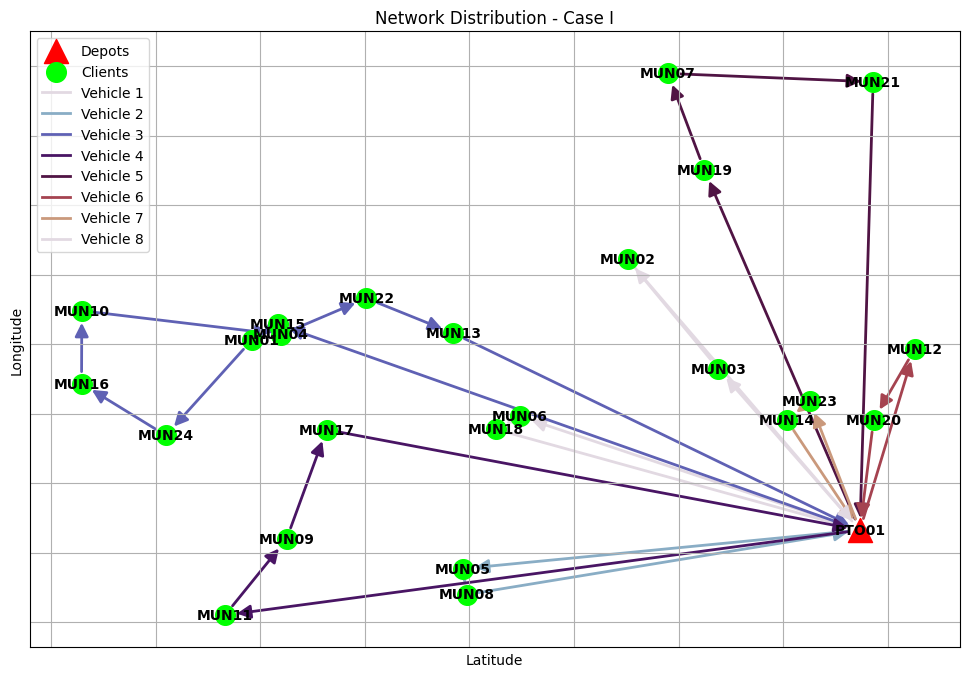

─────────────────────────────────────────  Solver Completed for Case 'I' ──────────────────────────────────────────

───────────────────────────────────────────────────────────────────────────────────────────────────────────────────

───────────────────────────────────────────────────────────────────────────────────────────────────────────────────

──────────────────────────────────────────   Start Solver for Case 'II' ───────────────────────────────────────────

 Loading core data for II...

 Loading fuel stations (scenario II)

 Building solver instance for case II...

─────────────────────────────────────────── Case 'II' → Initialization ────────────────────────────────────────────

→ Converting coordinates...

→ Adjusting indices...

→ Initializing visualizer...

─────────────────────────────────────────── Generating Model Components ───────────────────────────────────────────

✓ Sets defined

✓ Parameters initialized

✓ Variables declared

✓ Constraints built

✓ Objective function set

─────────────────────────────────────── Case 'II' Initialization Completed ────────────────────────────────────────

 Cleaning up temporary variables

 Solving optimization model...

───────────────────────────────────────────────  Solving Case 'II' ────────────────────────────────────────────────

SCIP version 9.2.2 [precision: 8 byte] [memory: block] [mode: optimized] [LP solver: SoPlex 7.1.4] [GitHash: 416226a4f8]
Copyright (c) 2002-2025 Zuse Institute Berlin (ZIB)

External libraries: 
  SoPlex 7.1.4         Linear programming solver developed at Zuse Institute Berlin (soplex.zib.de) [GitHash: 7c53d552]
  CppAD 20180000.0     Algorithmic Differentiation of C++ algorithms developed by B. Bell (github.com/coin-or/CppAD)
  TinyCThread 1.2      small portable implementation of the C11 threads API (tinycthread.github.io)
  MPIR 3.0.0           Multiple Precision Integers and Rationals Library developed by W. Hart (mpir.org)
  ZIMPL 3.6.2          Zuse Institute Mathematical Programming Language developed by T. Koch (zimpl.zib.de)
  AMPL/MP 690e9e7      AMPL .nl file reader library (github.com/ampl/mp)
  PaPILO 2.4.2         parallel presolve for integer and linear optimization (github.com/scipopt/papilo) (built with TBB) [GitHash: 4b399c4c]
  Nauty 2.8.8          Computing Graph A

────────────────────────────────────────────────  Case 'II' Solved ────────────────────────────────────────────────

 Solution successfully saved to solution.csv.

──────────────────────────────────────────────   Visualizing Case II ──────────────────────────────────────────────

 Graph and label map cleared.

 Nodes added to graph (depots, clients, stations).

 Displaying network plot...

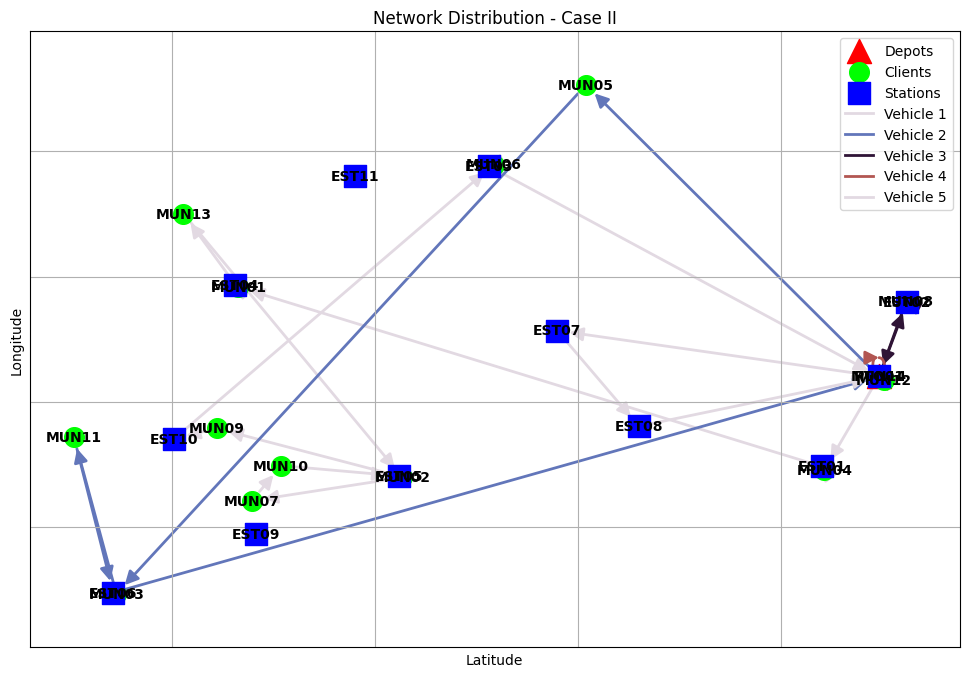

─────────────────────────────────────────  Solver Completed for Case 'II' ─────────────────────────────────────────

───────────────────────────────────────────────────────────────────────────────────────────────────────────────────

───────────────────────────────────────────────────────────────────────────────────────────────────────────────────

──────────────────────────────────────────   Start Solver for Case 'III' ──────────────────────────────────────────

 Loading core data for III...

 Loading fuel stations (scenario II)

 Loading toll data (scenario III)

 Building solver instance for case III...

─────────────────────────────────────────── Case 'III' → Initialization ───────────────────────────────────────────

→ Converting coordinates...

→ Adjusting indices...

→ Initializing visualizer...

─────────────────────────────────────────── Generating Model Components ───────────────────────────────────────────

✓ Sets defined

✓ Parameters initialized

✓ Variables declared

✓ Constraints built

✓ Objective function set

─────────────────────────────────────── Case 'III' Initialization Completed ───────────────────────────────────────

 Cleaning up temporary variables

 Solving optimization model...

───────────────────────────────────────────────  Solving Case 'III' ───────────────────────────────────────────────

SCIP version 9.2.2 [precision: 8 byte] [memory: block] [mode: optimized] [LP solver: SoPlex 7.1.4] [GitHash: 416226a4f8]
Copyright (c) 2002-2025 Zuse Institute Berlin (ZIB)

External libraries: 
  SoPlex 7.1.4         Linear programming solver developed at Zuse Institute Berlin (soplex.zib.de) [GitHash: 7c53d552]
  CppAD 20180000.0     Algorithmic Differentiation of C++ algorithms developed by B. Bell (github.com/coin-or/CppAD)
  TinyCThread 1.2      small portable implementation of the C11 threads API (tinycthread.github.io)
  MPIR 3.0.0           Multiple Precision Integers and Rationals Library developed by W. Hart (mpir.org)
  ZIMPL 3.6.2          Zuse Institute Mathematical Programming Language developed by T. Koch (zimpl.zib.de)
  AMPL/MP 690e9e7      AMPL .nl file reader library (github.com/ampl/mp)
  PaPILO 2.4.2         parallel presolve for integer and linear optimization (github.com/scipopt/papilo) (built with TBB) [GitHash: 4b399c4c]
  Nauty 2.8.8          Computing Graph A

───────────────────────────────────────────────  Case 'III' Solved ────────────────────────────────────────────────

 Solution successfully saved to solution.csv.

─────────────────────────────────────────────   Visualizing Case III ──────────────────────────────────────────────

 Graph and label map cleared.

 Nodes added to graph (depots, clients, stations).

 Displaying network plot...

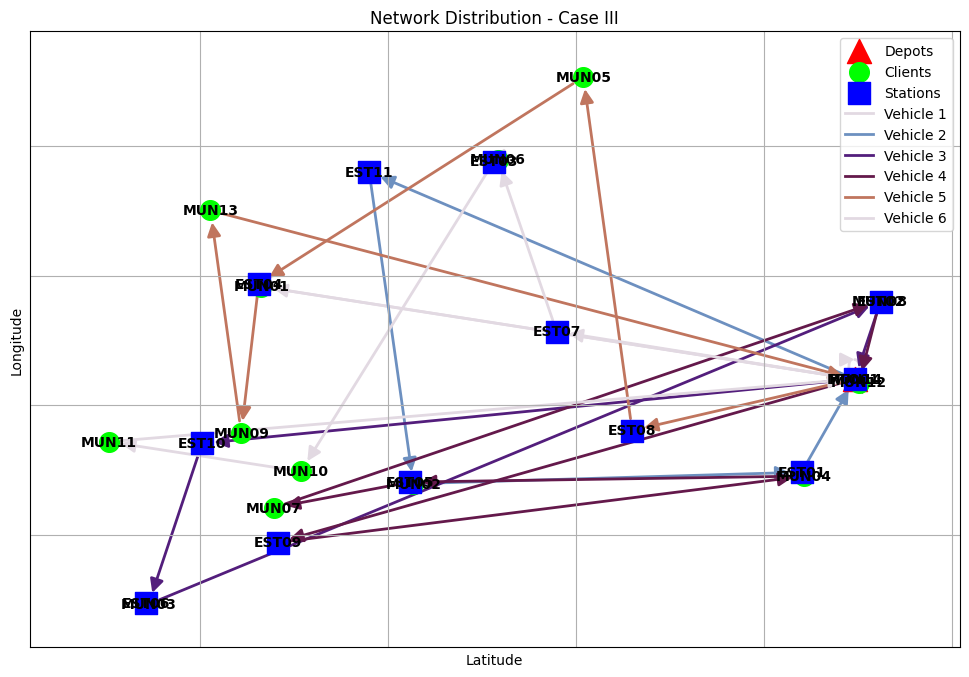

────────────────────────────────────────  Solver Completed for Case 'III' ─────────────────────────────────────────

───────────────────────────────────────────────────────────────────────────────────────────────────────────────────

In [12]:
# Iterate through all subdirectories inside the "data" folder, each representing a test case
for pathname in glob.glob("data/*"):
    case: Literal["I", "II", "III"] = os.path.basename(pathname)

    console.rule(style="red")
    console.rule(Text(f"  Start Solver for Case {case!r}", style="bold purple"), style="red")

    # Load core data files
    console.print(f"[cyan] Loading core data for [bold]{case}[/bold]...")
    depots: DataFrame = pd.read_csv(os.path.join(pathname, "depots.csv"), index_col=0)
    clients: DataFrame = pd.read_csv(os.path.join(pathname, "clients.csv"), index_col=0)
    vehicles: DataFrame = pd.read_csv(os.path.join(pathname, "vehicles.csv"), index_col=0)

    # Load optional data for scenario II
    if pathname.endswith("II"):
        console.print("[cyan] Loading fuel stations (scenario II)")
        stations: DataFrame = pd.read_csv(os.path.join(pathname, "stations.csv"), index_col=0)

    # Load optional data for scenario III
    if pathname.endswith("III"):
        console.print("[cyan] Loading toll data (scenario III)")
        tolls: DataFrame = pd.read_csv(os.path.join(pathname, "tolls.csv"), index_col=0)

    # Build solver instance
    console.print(f"[yellow] Building solver instance for case [bold]{case}[/bold]...")
    solver: AbstractSolver = AbstractSolver(
        case,
        depots,
        clients,
        vehicles,
        globals().get("stations"),  # If defined, else None
        globals().get("tolls"),     # If defined, else None
    )

    # Free up memory — especially useful in notebooks
    console.print("[magenta] Cleaning up temporary variables")
    try:
        del depots
        del clients
        del vehicles
        del stations
        del tolls
    except NameError:
        pass  # Some variables may not exist, e.g., stations in scenario I

    # Solve the model and export the results
    console.print("[green] Solving optimization model...")
    status: SolverVisualizer = solver.solve(
        os.path.join("models", case, "solution.csv"),
        verbose=True
    )
    status.display()

    console.rule(Text(f" Solver Completed for Case {case!r}", style="bold purple"), style="red")
    console.rule(style="red")